In [1]:
import os

os.environ["NUM_CORES"] = "6"
os.environ["MKL_NUM_THREADS"]= os.environ["NUM_CORES"]
os.environ["OMP_NUM_THREADS"]= os.environ["NUM_CORES"]

%load_ext autoreload
%autoreload
%config Completer.use_jedi=False

In [24]:
import time
import os
from pathlib import Path

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from dyn_fed.data.mnist import MNist
import dyn_fed as df

In [3]:
X_train, y_train, X_test, y_test = df.data.mnist.load_data()

In [4]:
torch_home = Path('/Users/sashlinreddy/.torch/datasets/').expanduser()

In [5]:
torch_home

PosixPath('/Users/sashlinreddy/.torch/datasets')

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

In [7]:
trainset = torchvision.datasets.MNIST(
    torch_home,
    download=True,
    train=True,
    transform=transform
)

In [8]:
valset = torchvision.datasets.MNIST(
    torch_home,
    download=True,
    train=False,
    transform=transform
)

In [44]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=64,
    shuffle=False
)

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


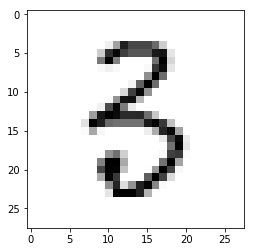

In [11]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [72]:
# input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.LogSoftmax(dim=1))

# model = nn.Sequential(
#     nn.Linear(input_size, output_size),
#     nn.Sigmoid(),
# )
# model = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=3),
#     nn.ReLU(),
#     nn.Conv2d(6, 12, kernel_size=5),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Linear(12 * 4 * 4, 120),
#     nn.ReLU(),
#     nn.Linear(120, 60),
#     nn.ReLU(),
#     nn.Linear(60, 10)

# )

class SimpleCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.fc1 = nn.Linear(12 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Flatten
        x = x.reshape(-1, 12 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [74]:
n_batches = len(iter(trainloader))

In [75]:
time0 = time.time()
epochs = 5
for e in tqdm(range(epochs)):
    running_loss = 0
    epoch_losses = []
    train_corr = 0
    train_total = 0
    for images, labels in tqdm(trainloader, total=n_batches):
        # Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        _, y_pred = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_corr += (y_pred == labels).sum().item()
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        # running_loss += loss.item()
        epoch_losses.append(loss.item())
        
    train_acc = train_corr / train_total
        
    epoch_loss = np.mean(epoch_losses)
    
    correct = 0
    total = 0
    test_losses = []
    with torch.no_grad():
        for x_val, y_val in valloader:
            y_pred_val = model(x_val)
            batch_test_loss = criterion(output, labels)
            test_losses.append(batch_test_loss.numpy())
            _, predicted = torch.max(y_pred_val.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()
            
        test_loss = np.mean(test_losses)
        test_acc = correct / total
        
    print(
        f"Epoch {e} - Training loss: {epoch_loss:.3f}, test_loss={test_loss:.3f}, "
        f"train_acc={train_acc:.3f}, test_acc={test_acc:.3f}"
    )
    
print("\nTraining Time (in minutes) =",(time.time()-time0)/60)

Epoch 0 - Training loss: 0.493, test_loss=0.2687416970729828, train_acc=0.8470166666666666, test_acc=0.9591


Epoch 1 - Training loss: 0.091, test_loss=0.08455823361873627, train_acc=0.9708666666666667, test_acc=0.9788


Epoch 2 - Training loss: 0.062, test_loss=0.006768633611500263, train_acc=0.9808333333333333, test_acc=0.985


Epoch 3 - Training loss: 0.047, test_loss=0.004045563284307718, train_acc=0.9853166666666666, test_acc=0.9857


Epoch 4 - Training loss: 0.038, test_loss=0.006270758341997862, train_acc=0.9878, test_acc=0.9848


Training Time (in minutes) = 1.4607041835784913


In [43]:
valdataset = iter(valloader)

In [47]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98.870 %


In [57]:
images.size()

torch.Size([16, 1, 28, 28])